# 電力尖峰負載預測（DSAI 作業一）

## Description
根據台電歷史資料，預測未來七天的"電力尖峰負載"(MW)。

### To do:
1. 把兩份csv檔合併
2. 可以自行設定訓練資料的區間
3. 可以自行設定要預測的區間
4. 改成預測區間7天
5. 增加前七天的尖峰負載作為feature
6. 測試前n個禮拜(測試n個禮拜前跟下個禮拜最相關)
7. 各features與尖峰負載的相關係數
8. 整理jupyter notebook

### Parts
1. Import data
2. Select features
3. Construct training and testing data
4. Construct Neural Network Model
5. Training
6. Testing

## Part 0: Import necessary libraies

In [122]:
%matplotlib inline
import pandas as pd
import csv
from requests_html import HTMLSession
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import json
from keras.models import model_from_json

## Part 1: Import data
目前總共使用兩種資料來訓練模型<br>
1. 台電提供的過去電力供需資料
2. 中央氣象局提供的過去天氣資料。

### 1. Past Power Supply and Demand Information
資料來源：[台灣電力公司_過去電力供需資訊](https://data.gov.tw/dataset/19995)<br>
'20170101_20190131.csv' 存放從 2017/01/01 ~ 2019/01/31 的相關電力資料。

In [123]:
data = pd.read_csv('data/20170101_20190131.csv')
data.head()

,日期,淨尖峰供電能力(MW),尖峰負載(MW),備轉容量(MW),備轉容量率(%),工業用電(百萬度),民生用電(百萬度),核一#1(萬瓩),核一#2(萬瓩),核二#1(萬瓩),...,大觀二,明潭,碧海,立霧,龍澗,卓蘭,水里,其他小水力,風力發電,太陽能發電
0,20170101,24957.0,22886,2071.0,9.05,268.503,196.229,0,62.8,0.0,...,28.6,65.9,0.0,0.0,0.6,2.0,0.0,6.2,12.2,0.0
1,20170102,26035.0,24483,1552.0,6.34,280.534,205.022,0,62.8,0.0,...,49.3,94.0,0.0,0.0,0.7,2.2,0.0,6.0,12.7,0.0
2,20170103,29152.0,28131,1021.0,3.63,320.449,234.193,0,62.7,0.0,...,39.5,68.3,0.0,0.0,0.4,3.9,0.0,4.0,25.2,0.0
3,20170104,29757.0,28485,1272.0,4.47,329.623,240.898,0,62.8,0.0,...,40.9,68.3,0.0,0.0,0.4,3.1,0.0,15.9,9.3,0.0
4,20170105,30065.0,28336,1729.0,6.10,330.137,241.273,0,62.8,0.0,...,26.3,61.5,0.0,0.0,0.3,2.1,0.0,9.3,6.5,0.0


### 2. Past weather data

使用網路爬蟲，從[觀測資料查詢系統](https://e-service.cwb.gov.tw/HistoryDataQuery/index.jsp)抓下2017-01~2019-01的氣象資料，並存到'weather.csv'

In [124]:
heads = []
session = HTMLSession()
year = 2017
month = 1
with open('data/weather.csv', 'w', encoding='utf-8-sig') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    
    # Write the headers
    url = 'https://e-service.cwb.gov.tw/HistoryDataQuery/MonthDataController.do?command=viewMain&station=467490&stname=%25E8%2587%25BA%25E4%25B8%25AD&datepicker=2017-01'
    response = session.get(url)
    ths = response.html.find('#MyTable tbody .second_tr th')
    for i in range(35):
        heads.append(ths[i].text)
    filewriter.writerow(heads)

    # Write the weather data
    while True:
        url = 'https://e-service.cwb.gov.tw/HistoryDataQuery/MonthDataController.do?command=viewMain&station=467490&stname=%25E8%2587%25BA%25E4%25B8%25AD&datepicker=' + str(year) + '-' + '{0:0>2}'.format(str(month))        
        response = session.get(url)
        trs = response.html.find('#MyTable tbody tr')
        for tr in trs[3:]:
            tds = tr.find('td')
            to_write = [str(year)+'{0:0>2}'.format(str(month))+tds[0].text]
            for i in range(1,35):
                to_write.append(tds[i].text)
            filewriter.writerow(to_write)
        
        month += 1
        if month == 13:
            month = 1
            year += 1
        if year == 2019 and month == 2:
            break

In [125]:
data = pd.read_csv('data/weather.csv')
data.head()

,觀測時間 (day),測站氣壓 (hPa),海平面氣壓 (hPa),測站最高氣壓 (hPa),測站最高氣壓時間 (LST),測站最低氣壓 (hPa),測站最低氣壓時間 (LST),氣溫 (℃),最高氣溫 (℃),最高氣溫時間 (LST),...,一小時最大降水量 (mm),一小時最大降水量起始時間 (LST),日照時數 (hr),日照率 (%),全天空日射量 (MJ/㎡),能見度 (km),A型蒸發量 (mm),日最高紫外線指數,日最高紫外線指數時間 (LST),總雲量 (0~10)
0,20170101,1010.3,1020.4,1012.8,2017-01-01 08:28,1007.9,2017-01-01 14:53,20.0,25.9,2017-01-01 13:41,...,0.0,NaN,9.6,90.3,15.36,12.0,2.8,4,2017-01-01 13:00,1.1
1,20170102,1009.4,1019.4,1011.7,2017-01-02 09:11,1007.3,2017-01-02 15:22,20.9,25.9,2017-01-02 12:21,...,0.0,NaN,8.2,77.1,14.51,9.0,0.7,5,2017-01-02 12:00,4.3
2,20170103,1008.6,1018.7,1010.8,2017-01-03 09:44,1006.4,2017-01-03 15:07,21.1,26.3,2017-01-03 13:01,...,0.0,NaN,8.4,78.9,14.11,11.1,2.3,4,2017-01-03 12:00,3.6
3,20170104,1007.5,1017.5,1009.5,2017-01-04 09:49,1005.4,2017-01-04 14:19,21.0,25.6,2017-01-04 13:39,...,0.0,NaN,4.2,39.4,10.93,10.8,2.7,4,2017-01-04 12:00,5.6
4,20170105,1006.6,1016.6,1008.3,2017-01-05 08:59,1004.3,2017-01-05 14:52,20.8,26.1,2017-01-05 14:01,...,0.0,NaN,3.3,31.0,10.78,8.1,0.3,4,2017-01-05 12:00,7.3


## Part 2: Select features

By computing the correlation coefficient, try to find out what variables are more relevant to the peak load.<br>
計算各特徵與尖峰負載的相關係數，找出高相關度的特徵作為模型訓練的 features 。

In [126]:
df1 = pd.read_csv("data/20170101_20190131.csv")
df2 = pd.read_csv("data/weather.csv")

# Funtion for plotting figure with 2 y-axis
def plot_2y_fig(x, y1, y2, x_label, y1_label, y2_label):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color = 'red')
    ax1.plot(x,y1, color='red', linewidth=2.0, linestyle=':')
    ax1.tick_params(axis='y', labelcolor='red')

    ax2 = ax1.twinx()
    ax2.set_ylabel(y2_label, color = 'blue')
    ax2.plot(x,y2, color='blue', linewidth=2.0, linestyle=':')
    ax2.tick_params(axis='y', labelcolor='blue')
    fig.tight_layout()
    plt.show()

### Weather data and peak load

透過計算各天氣數據與尖峰負載的相關係數，找出具有高相關度（相關係數 > 0.7）的變數：氣溫、最低氣溫、露點溫度

[[1.         0.71861961]
 [0.71861961 1.        ]]


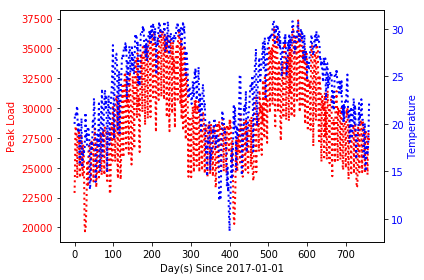

In [127]:
# Temperature: corr_coef = 0.7186
y1 = df1.iloc[:, 2]
y2 = df2.iloc[:, 7]
print(np.corrcoef([y1, y2]))
x = range(761)

plot_2y_fig(x, y1, y2, 'Day(s) Since 2017-01-01', 'Peak Load', 'Temperature')

[[1.         0.73255793]
 [0.73255793 1.        ]]


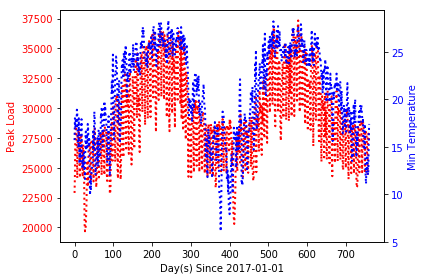

In [128]:
# Temperature Min: corr_coef = 0.7325
y1 = df1.iloc[:, 2]
y2 = df2.iloc[:, 10]
print(np.corrcoef([y1, y2]))

x = range(761)
plot_2y_fig(x, y1, y2, 'Day(s) Since 2017-01-01', 'Peak Load', 'Min Temperature')

[[1.        0.7154757]
 [0.7154757 1.       ]]


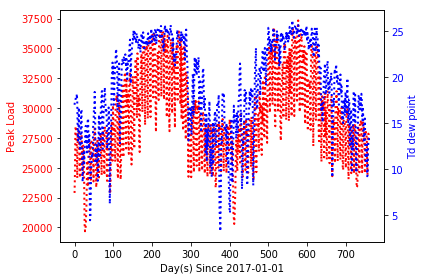

In [129]:
# Td dew point(露點溫度): corr_coef = 0.7154
y1 = df1.iloc[:, 2]
y2 = df2.iloc[:, 12]
print(np.corrcoef([y1, y2]))
 
x = range(761)
plot_2y_fig(x, y1, y2, 'Day(s) Since 2017-01-01', 'Peak Load', 'Td dew point')

### Holidays and peak load
了解**假日與否**和**尖峰負載**的相關度。<br>
由於一次比較整年度的資料會受到氣溫等因素影響，因此將比較的尺度縮小到月份。<br>
以下計算2017年1月～2018年12月（共24個月）的假日與尖峰負載的相關係數，並且將國定假日與補班日列入考量。<br>
24個月份的相關係數平均為0.86，顯示**假日與否**和**尖峰負載**具有**高度相關。**

In [130]:
# Holidays
holidays = [20170101, 20170102, 20170127, 21070128, \
            20170129, 20170130, 20170131, 20170201, \
            20170225, 20170226, 20170227, 20170228, \
            20170401, 20170402, 20170403, 20170404, \
            20170527, 20170528, 20170529, 20170530, \
            20171004, 20171007, 20171008, 20171009, \
            20171010, 20171230, 20171231, 20180101, \
            20180215, 20180216, 20180217, 20180218, \
            20180219, 20180220, 20180228, 20180404, \
            20180405, 20180406, 20180407, 20180408, \
            20180616, 20180617, 20180618, 20180922, \
            20180923, 20180924, 20181010, 20181229, \
            20181230, 20181231, 20190101, 20190202, \
            20190203, 20190204, 20190205, 20190206, \
            20190207, 20190208, 20190209, 20190210, \
            20190228, 20190301, 20190302, 20190303, \
            20190404, 20190405, 20190406, 20190407]

# Weekend but workday
add_workdays = [20170218, 20170603, 20170930, 20180331, 20181222, 20190119, 20190223]
month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Holiday encoding
def holiday_encoding(dates):
    hol = []
    week = []
    for date in dates:
        if date in holidays:
            hol.append(0)
        else:
            hol.append(1)
            
        if date in add_workdays:
            week.append(1)
        elif datetime.strptime(str(date), '%Y%m%d').weekday() == 5:
            week.append(0)
            hol[len(hol)-1] = 0
        elif datetime.strptime(str(date), '%Y%m%d').weekday() == 6:
            week.append(0)
            hol[len(hol)-1] = 0
        else:
            week.append(1)
    return hol, week

df1 = pd.read_csv("data/20170101_20190131.csv")
df2 = pd.read_csv("data/weather.csv")

start = 0
corr_arr = []

# Encoding holidays as '0', otherwise '1'
for i, j in zip(range(24), month_days):
    end = start + j
    dates = df2.iloc[start:end, 0]
    y3, y2 = holiday_encoding(dates)
    
    print(str(dates[start]) + '~' + str(dates[end - 1]) + ':', end = ' ')
    y1 = df1.iloc[start:end, 2]
    start += j
    corr = np.corrcoef([y1, y2])[0,1]
    corr_arr.append(corr)
    print(round(corr, 3))
print('\nCorrcoef Mean:', np.mean(corr_arr))

20170101~20170131: 0.473
20170201~20170228: 0.653
20170301~20170331: 0.96
20170401~20170430: 0.694
20170501~20170531: 0.719
20170601~20170630: 0.747
20170701~20170731: 0.906
20170801~20170831: 0.898
20170901~20170930: 0.899
20171001~20171031: 0.627
20171101~20171130: 0.943
20171201~20171231: 0.959
20180101~20180131: 0.812
20180201~20180228: 0.327
20180301~20180331: 0.94
20180401~20180430: 0.666
20180501~20180531: 0.686
20180601~20180630: 0.771
20180701~20180731: 0.867
20180801~20180831: 0.763
20180901~20180930: 0.819
20181001~20181031: 0.907
20181101~20181130: 0.902
20181201~20181231: 0.817

Corrcoef Mean: 0.7814579295587117


以2017年3月份作為示例作圖：

Corr_coef: 0.96


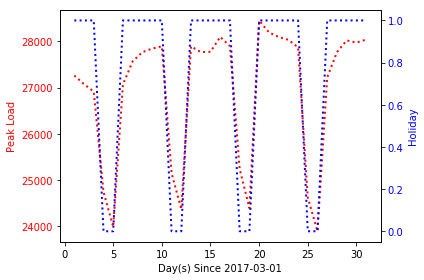

In [131]:
y1 = df1.iloc[59:90, 2]
dates = df2.iloc[59:90, 0]
y2, y3 = holiday_encoding(dates)
corr = np.corrcoef([y1, y2])[0,1]
print('Corr_coef:', round(corr, 3))

x = range(1, 32)
plot_2y_fig(x, y1, y2, 'Day(s) Since 2017-03-01', 'Peak Load', 'Holiday')

### Comparison with historical data

1. 比較本週與上週尖峰負載的關係。<br>
2. 比較今年與去年同期的關係。

#### Compare with last week data
計算每週數據與上週數據的相關係數，2017、2018兩年相關係數的平均為0.739，顯示**本週數據與上週數據具有高度相關**。

In [132]:
df1 = pd.read_csv("data/20170101_20190131.csv")
start = 0
end = 7
corr_arr = []
for i in range(96):
    last_week = df1.iloc[start:end, 2]
    start += 7
    end += 7
    this_week = df1.iloc[start:end, 2]
    corr = np.corrcoef([last_week, this_week])[0,1]
    corr_arr.append(corr)
    #print('Corr_coef:', round(corr, 3))
print('Corr_coef Mean:', np.mean(corr_arr))

Corr_coef Mean: 0.7395602846709592


#### Compare with last year data
計算2018年與2017年尖峰負載的相關係數為0.625（中度相關）<br>
若以一週尺度來計算的話為低度相關。

Corr_coef: 0.625


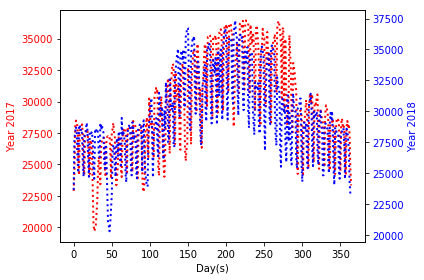

In [133]:
df1 = pd.read_csv("data/20170101_20190131.csv")
start = 365
end = 730

last_year = df1.iloc[start-365:end-365, 2]
this_year = df1.iloc[start:end, 2]
corr = np.corrcoef([last_year, this_year])[0,1]
print('Corr_coef:', round(corr, 3))

x = range(365)
plot_2y_fig(x, last_year, this_year, 'Day(s)', 'Year 2017', 'Year 2018')

## Part 3: Construct training and testing data

最後決定採用假日與否、最低溫度、最高溫度、台灣電力公司_未來一週電力供需預測，共四項特徵來做模型訓練與預測。

In [183]:
df1 = pd.read_csv("data/20170101_20190131.csv")
df2 = pd.read_csv("data/weather.csv")
dates = df1.iloc[:, 0] # type(dates) == <class 'pandas.core.series.Series'>
y = df1.iloc[:,2].values # get the daily peak load, type == <class 'pandas.core.series.Series'>

holidays, weekdays = holiday_encoding(dates)
temperature = df2.iloc[:, 7]
min_temperature = df2.iloc[:, 10]
max_temperature = df2.iloc[:, 8]
peak_load = df1.iloc[:,2]
td_dew = df2.iloc[:, 12]

x = []
test = []
for holiday, i, j, peak in zip(holidays, min_temperature, max_temperature, peak_load):
    x.append([holiday, i, j, peak-20.73])

x = np.asarray(x)
y = np.reshape(y, (761, 1))

(x_train, x_test) = (x[:600], x[600:])
(y_train, y_test) = (y[:600], y[600:])

print('x_train.shape, y_train.shape:')
print(x_train.shape, y_train.shape)
print('x_test.shape, y_test.shape:')
print(x_test.shape, y_test.shape)

#for i in range(10):
#    print(x_train[i])

x_train.shape, y_train.shape:
(600, 4) (600, 1)
x_test.shape, y_test.shape:
(161, 4) (161, 1)


### Constructing a neural network model

In [135]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [184]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(units=10, input_dim=4))
for i in range(10):
    model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1, activation='linear'))
model.compile(loss=root_mean_squared_error, optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_166 (Dense)            (None, 10)                50        
_________________________________________________________________
dense_167 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_168 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_169 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_170 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_171 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_172 (Dense)            (None, 10)                110       
__________

In [185]:
# training
print('Training -----------')
model.fit(x_train, y_train, epochs=100, batch_size=7, validation_split=0.2)

Training -----------
Train on 480 samples, validate on 120 samples
Epoch 1/100
480/480 [==============================] - 8s 16ms/step - loss: 18528.5765 - val_loss: 1665.3090
Epoch 2/100
480/480 [==============================] - 1s 1ms/step - loss: 337.5366 - val_loss: 929.4958
Epoch 3/100
480/480 [==============================] - 1s 1ms/step - loss: 282.4370 - val_loss: 114.4226
Epoch 4/100
480/480 [==============================] - 1s 1ms/step - loss: 131.1124 - val_loss: 310.7746
Epoch 5/100
480/480 [==============================] - 1s 1ms/step - loss: 202.0772 - val_loss: 55.2535
Epoch 6/100
480/480 [==============================] - 1s 1ms/step - loss: 129.9452 - val_loss: 124.8460
Epoch 7/100
480/480 [==============================] - 1s 1ms/step - loss: 191.0269 - val_loss: 181.5007
Epoch 8/100
480/480 [==============================] - 1s 1ms/step - loss: 209.8339 - val_loss: 99.7951
Epoch 9/100
480/480 [==============================] - 1s 1ms/step - loss: 107.2336 - val_l

Epoch 78/100
480/480 [==============================] - 1s 2ms/step - loss: 149.1368 - val_loss: 186.3892
Epoch 79/100
480/480 [==============================] - 1s 1ms/step - loss: 165.4215 - val_loss: 23.3555
Epoch 80/100
480/480 [==============================] - 1s 1ms/step - loss: 209.4095 - val_loss: 517.3960
Epoch 81/100
480/480 [==============================] - 1s 2ms/step - loss: 163.4149 - val_loss: 2.0153
Epoch 82/100
480/480 [==============================] - 1s 1ms/step - loss: 129.1203 - val_loss: 572.4125
Epoch 83/100
480/480 [==============================] - 1s 1ms/step - loss: 154.3918 - val_loss: 187.0597
Epoch 84/100
480/480 [==============================] - 1s 2ms/step - loss: 109.8294 - val_loss: 164.5426
Epoch 85/100
480/480 [==============================] - 1s 2ms/step - loss: 84.2223 - val_loss: 98.8859
Epoch 86/100
480/480 [==============================] - 1s 2ms/step - loss: 141.2611 - val_loss: 120.0504
Epoch 87/100
480/480 [=============================

In [186]:
# test
print('\nTesting ------------')

data_x = x_test
data_y = y_test
y_pred = model.predict(data_x)

diff = y_pred - data_y
percentDiff = (diff / data_y) * 100
absPercentDiff = np.abs(percentDiff)

# Compute the mean and standard deviation
# of the absolute percentage difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print('[INFO] mean: {:.2f}%, std: {:.2f}%'.format(mean, std))

print('-'*40)

for i in range(len(y_pred)):
    #print(x_test[i], y_test[i][0] , int(y_pred[i][0].round()))
    print(int(y_pred[i][0].round()) - data_y[i][0], end=' ')
print('\n\n均方根誤差:', np.mean(np.abs(y_pred - data_y)))


Testing ------------
[INFO] mean: 0.06%, std: 0.01%
----------------------------------------
-17 -14 -13 -17 -18 -17 -16 -17 -12 -12 -16 -16 -16 -18 -18 -14 -11 -16 -16 -17 -16 -17 -13 -11 -16 -17 -17 -17 -17 -13 -10 -11 -15 -16 -16 -17 -13 -11 -15 -17 -17 -17 -18 -13 -11 -16 -16 -12 -18 -19 -14 -11 -16 -17 -18 -17 -18 -14 -13 -17 -16 -17 -17 -17 -15 -15 -19 -18 -18 -20 -18 -13 -12 -16 -17 -18 -17 -17 -15 -13 -18 -18 -18 -18 -17 -15 -13 -18 -19 -17 -20 -20 -16 -16 -22 -19 -21 -19 -19 -15 -15 -19 -19 -17 -16 -18 -16 -16 -21 -20 -23 -21 -19 -17 -14 -22 -22 -22 -20 -20 -16 -15 -20 -18 -18 -20 -21 -20 -18 -19 -19 -22 -22 -19 -16 -17 -20 -19 -19 -19 -18 -16 -16 -20 -20 -24 -25 -22 -21 -17 -24 -27 -25 -23 -22 -21 -20 -23 -23 -20 -16 

均方根誤差: 17.41600349378882


## Model saving and loading

#### Save model structure to a json file

In [189]:
json_string = model.to_json()
with open('model/my_model.json', 'w') as f:
    json.dump(json_string, f)

#### Save model weights to a h5 file

In [190]:
model.save_weights('model/my_model_weights.h5')

#### Create a new model by structure and weights

In [191]:
with open('model/my_model.json', 'r') as f:
    weights = json.load(f)

new_model = model_from_json(weights)
new_model.load_weights('model/my_model_weights.h5')

## Predict One-week Peak Load

In [109]:
# Not used code: This code grabs weather data from the website
one_week = pd.read_json('data/one_week_forecast_0331.json', orient='columns')

MinT_forecast = []
MaxT_forecast = []

MinT_week = one_week.loc['resources'][0]['resource']['data']['agrWeatherForecasts']['weatherForecasts']['location'][1]['weatherElements']['MinT']['daily']
MaxT_week = one_week.loc['resources'][0]['resource']['data']['agrWeatherForecasts']['weatherForecasts']['location'][1]['weatherElements']['MaxT']['daily']

for MinT_daily, MaxT_daily in zip(MinT_week, MaxT_week):
    MinT_forecast.append(MinT_daily)
    MaxT_forecast.append(MaxT_daily)
    
print(MinT_forecast)
print(MaxT_forecast)

[{'dataDate': '2019-03-30', 'temperature': '21'}, {'dataDate': '2019-03-31', 'temperature': '19'}, {'dataDate': '2019-04-01', 'temperature': '17'}, {'dataDate': '2019-04-02', 'temperature': '18'}, {'dataDate': '2019-04-03', 'temperature': '18'}, {'dataDate': '2019-04-04', 'temperature': '20'}, {'dataDate': '2019-04-05', 'temperature': '20'}]
[{'dataDate': '2019-03-30', 'temperature': '29'}, {'dataDate': '2019-03-31', 'temperature': '27'}, {'dataDate': '2019-04-01', 'temperature': '25'}, {'dataDate': '2019-04-02', 'temperature': '26'}, {'dataDate': '2019-04-03', 'temperature': '28'}, {'dataDate': '2019-04-04', 'temperature': '28'}, {'dataDate': '2019-04-05', 'temperature': '29'}]


In [194]:
x_predict = [[1, 19, 25, 28700], [1, 20, 25, 28600], [0, 19, 24, 25700], [0, 19, 27, 24600], [0, 21, 28, 24300], [0, 21, 27, 24500],[1, 21, 28, 28500]]
x_predict = np.asarray(x_predict)
y_pred = new_model.predict(x_predict)

for i in y_pred:
    print(i[0]+17.416)

28718.249984375
28618.93553125
25720.703109375
24623.17771875
24325.144515625
24524.4706875
28521.156234375
